In [1]:
%matplotlib widget
import glob
import pandas as pd
import sys
import statistics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import Affine2D

Declare global paths and variables

In [13]:
OUTER_LOG_DIR = "/home/vagrant/mini-ndn/work/log"

NUM_NODES = 20
PUB_TIMING_VALS = [1000, 5000, 10000, 15000]
RUN_NUMBER_VALS = list(range(1, 4))

LOG_PREFIXES = ["psync/GEANT_L0", "chronosync/GEANT", "svs/GEANT_L0"]
LOG_PREFIX_LABELS = ["PSync - No Loss", "ChronoSync - No Loss", "SVS - No Loss"]
COLORS = ["blue", "orange", "red"]

Process all log files

In [3]:
def process_log(LOG_PREFIX):
    # Data variables
    TIMING_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    TIMING_DATA_50[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    TIMING_DATA_75[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    TIMING_DATA_90[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    SYNC_INT_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    SUCCESS_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    NUM_PUBLISHED_DATA[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]

    NUM_nInInterests[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]
    NUM_nOutData[LOG_PREFIX] = [[] for x in PUB_TIMING_VALS]

    for i_t, PUB_TIMING in enumerate(PUB_TIMING_VALS):
        for RUN_NUMBER in RUN_NUMBER_VALS:
            PUBLISHING_NODES = []

            # Let log directory and files
            LOG_NAME = "{}-{}-{}".format(LOG_PREFIX, PUB_TIMING, RUN_NUMBER)
            LOG_DIR = OUTER_LOG_DIR + '/' + LOG_NAME

            print("Processing", LOG_NAME)

            PUBLISHES = {}
            SYNCS = {}
            RECIEVES = {}
            SYNC_INTS = 0

            for logfile in glob.glob(LOG_DIR + "/*.log"):
                nodename = logfile.split('/')[-1].split('.')[0]
                df = pd.read_csv(logfile, header=None, names=['t', 'pid', 'tid', 'm'], skipinitialspace = True)
                df = df.replace(' "', '', regex=True).replace('"', '', regex=True)

                for index, row in df.iterrows():
                    t = datetime.strptime(row['t'], "%Y-%m-%d %H:%M:%S.%f")
                    ti = int((t - datetime.utcfromtimestamp(0)).total_seconds() * 1000)
                    m = row['m'].split('::')

                    if 'PUBL_MSG' in m[0]:
                        PUBLISHES[m[2]] = ti
                    if 'RECV_MSG' in m[0]:
                        continue
                        #if m[2] not in RECIEVES:
                            #RECIEVES[m[2]] = []
                        #RECIEVES[m[2]].append(ti)
                    if 'RECV_STATE' in m[0]:
                        if "chronosync" in LOG_PREFIX:
                            m[1] = m[1].split('/')
                            m[1].pop()
                            m[1] = "/".join(m[1])

                        msg = "{}={}".format(m[1], m[2])
                        if msg not in RECIEVES:
                            RECIEVES[msg] = []
                        RECIEVES[msg].append(ti)
                    if 'SEND_SYNC_INT' in m[0]:
                        SYNC_INTS += 1
            
            local_timing_data = []

            for msg in RECIEVES:
                if msg not in PUBLISHES:
                    print(msg, 'was received and never published :)')
                    continue

                pubtime = PUBLISHES[msg]
                recv_times = RECIEVES[msg]

                deltas = [x - pubtime for x in recv_times]
                publisher = msg.split('/')[3]
                if publisher not in PUBLISHING_NODES:
                    PUBLISHING_NODES.append(publisher)

                # Store global and local timing values
                TIMING_DATA[LOG_PREFIX][i_t].extend(deltas)
                local_timing_data.extend(deltas)
                
            # Get percentile global timing values
            TIMING_DATA_50[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 50))
            TIMING_DATA_75[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 75))
            TIMING_DATA_90[LOG_PREFIX][i_t].append(np.percentile(local_timing_data, 90))

            # Other metrics
            SYNC_INT_DATA[LOG_PREFIX][i_t].append(SYNC_INTS / len(PUBLISHES))
            SUCCESS_DATA[LOG_PREFIX][i_t].append((len([x for k in RECIEVES for x in RECIEVES[k]]) / (NUM_NODES - 1)) / len(PUBLISHES))
            NUM_PUBLISHED_DATA[LOG_PREFIX][i_t].append(len(PUBLISHES))

            nInInterests = 0
            nOutData = 0
            for startfile in glob.glob(LOG_DIR + "/report-start-*.status"):
                nodename = startfile.split('/')[-1].split('.')[0].split('-')[-1]
                endfile = startfile.replace('report-start', 'report-end')

                def read_status_file(filename):
                    status = {}
                    with open(filename, "r") as sf:
                        for line in sf.readlines():
                            if "Channels" in line:
                                break

                            if "=" in line:
                                line = line.strip()
                                v = line.split('=')
                                try:
                                    status[v[0]] = int(v[1])
                                except ValueError:
                                    status[v[0]] = v[1]
                    return status

                start = read_status_file(startfile)
                end = read_status_file(endfile)

                nInInterests += end['nInInterests'] - start['nInInterests']
                nOutData += end['nOutData'] - start['nOutData']

            NUM_nInInterests[LOG_PREFIX][i_t].append(nInInterests / len(PUBLISHES))
            NUM_nOutData[LOG_PREFIX][i_t].append(nOutData / len(PUBLISHES))

    print("Done", LOG_PREFIX)

In [4]:
TIMING_DATA = {}
TIMING_DATA_50 = {}
TIMING_DATA_75 = {}
TIMING_DATA_90 = {}
SYNC_INT_DATA = {}
SUCCESS_DATA = {}
NUM_PUBLISHED_DATA = {}

NUM_nInInterests = {}
NUM_nOutData = {}

for LOG_PREFIX in LOG_PREFIXES:
    process_log(LOG_PREFIX)

Processing psync/GEANT_L0-1000-1
Processing psync/GEANT_L0-1000-2
Processing psync/GEANT_L0-1000-3
Processing psync/GEANT_L0-5000-1
/ndn/by-site/by/svs_chat/by=8 was received and never published :)
Processing psync/GEANT_L0-5000-2
Processing psync/GEANT_L0-5000-3
Processing psync/GEANT_L0-10000-1
Processing psync/GEANT_L0-10000-2
Processing psync/GEANT_L0-10000-3
Processing psync/GEANT_L0-15000-1
Processing psync/GEANT_L0-15000-2
Processing psync/GEANT_L0-15000-3
Done psync/GEANT_L0
Processing chronosync/GEANT-1000-1
Processing chronosync/GEANT-1000-2
Processing chronosync/GEANT-1000-3
Processing chronosync/GEANT-5000-1
Processing chronosync/GEANT-5000-2
Processing chronosync/GEANT-5000-3
Processing chronosync/GEANT-10000-1
Processing chronosync/GEANT-10000-2
Processing chronosync/GEANT-10000-3
Processing chronosync/GEANT-15000-1
Processing chronosync/GEANT-15000-2
Processing chronosync/GEANT-15000-3
Done chronosync/GEANT
Processing svs/GEANT_L0-1000-1
Processing svs/GEANT_L0-1000-2
Pr

In [5]:
PUB_TIMING_VALS_SEC = [x/1000 for x in PUB_TIMING_VALS]

## Graphs

For each value of publishing timings, the experiment runs for the same amount of time regardless of the loss rate. The differences in the values indicate the randomness of the experiment (on the client).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

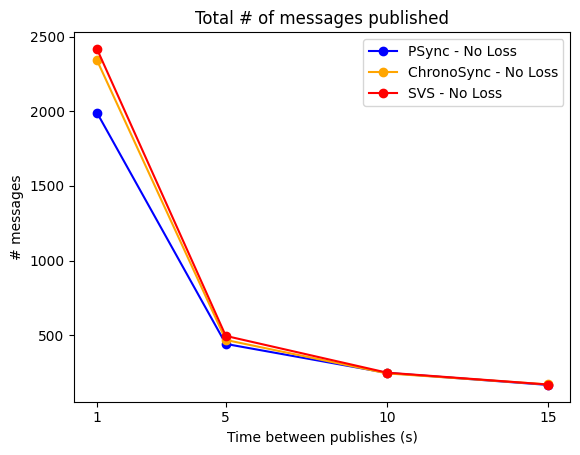

In [14]:
fig, ax = plt.subplots()
ax.set_title('Total # of messages published')
ax.set_ylabel('# messages')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = [sum(x)/len(x) for x in NUM_PUBLISHED_DATA[LOG_PREFIX]]
    ax.plot(PUB_TIMING_VALS_SEC, data, '-o', label=LOG_PREFIX_LABELS[i], color=COLORS[i])
    
ax.legend()

display(fig)
plt.close()

In [15]:
def do_plots(glob_data, ax, ninety=False, fmt='-^', label=True):
    for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
        data = glob_data[LOG_PREFIX]
        d = [np.percentile(x, 50) for x in data]
        yu = np.abs([np.percentile(x, 75) for x in data] - np.array(d))
        yl = np.abs([np.percentile(x, 25) for x in data] - np.array(d))

        trans = Affine2D().translate(-0.2+0.2 * i, 0.0) + ax.transData
        ax.errorbar(PUB_TIMING_VALS_SEC, d, yerr=[yl, yu],
                    fmt=fmt, color=COLORS[i], transform=trans,
                    solid_capstyle='projecting', capsize=4,
                    label=LOG_PREFIX_LABELS[i] if label else None)

        if ninety:
            ax.plot(PUB_TIMING_VALS_SEC, [np.percentile(x, 90) for x in data], ':', 
                    color=COLORS[i], transform=trans)

### Timing Plots

Time to delivery - dashed lines represent the 75th percentile (where applicable) and dotted lines represent the 90th percentile. The error bars indicate the 25th and 75th percentiles in the plot below.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

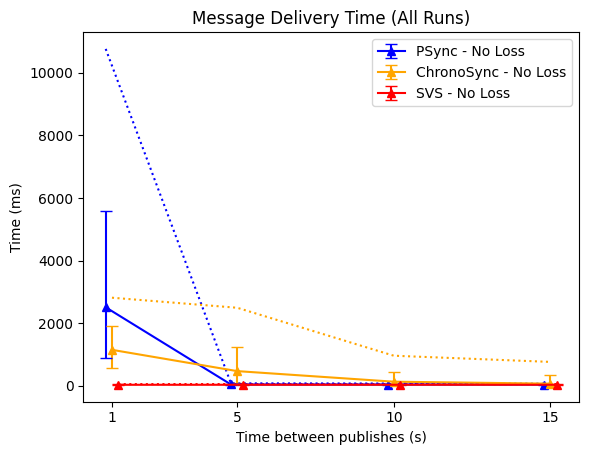

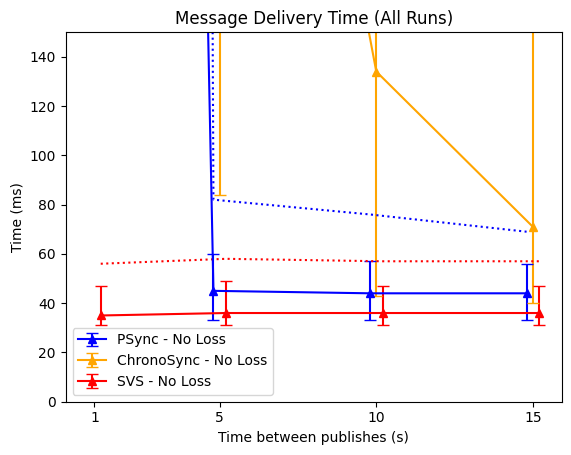

In [17]:
fig, ax = plt.subplots()
ax.set_title('Message Delivery Time (All Runs)')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

do_plots(TIMING_DATA, ax, ninety=True)

ax.legend()
display(fig)
ax.set_ylim(0, 150)
display(fig)
plt.close()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

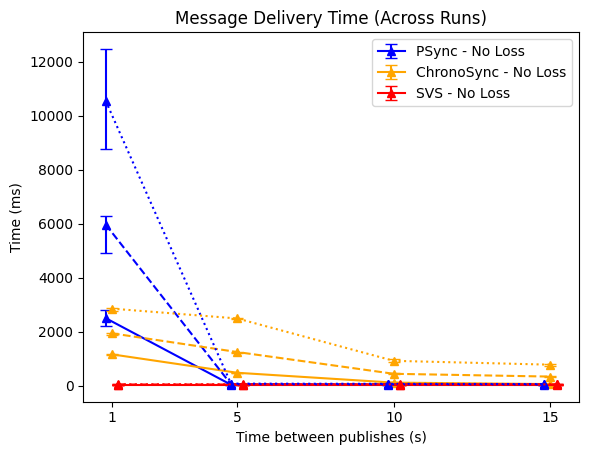

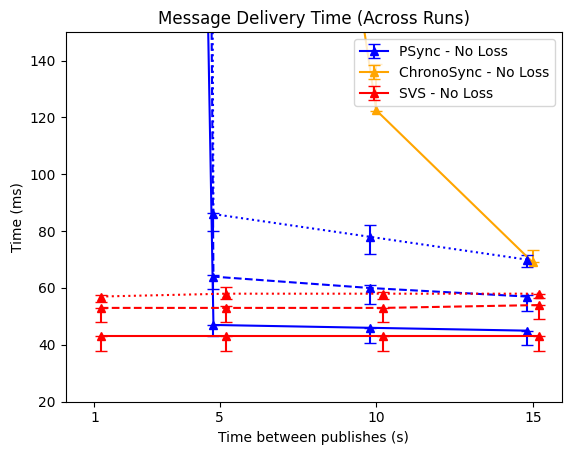

In [21]:
fig, ax = plt.subplots()
ax.set_title('Message Delivery Time (Across Runs)')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

do_plots(TIMING_DATA_50, ax)
do_plots(TIMING_DATA_75, ax, fmt='--^', label=False)
do_plots(TIMING_DATA_90, ax, fmt=':^', label=False)

ax.legend()
display(fig)
ax.set_ylim(20, 150)
display(fig)
plt.close()

### Sync Interests

Since the number of messages published is different in different runs, we calculate the published sync interests _per message published during the run_. This is counted at the sync clients (how many sync interests are sent out).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

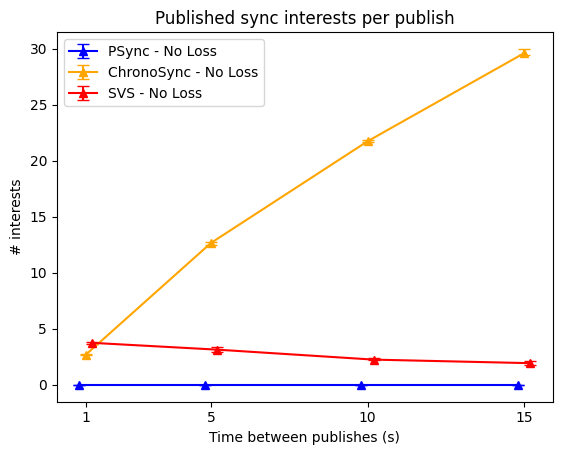

In [22]:
fig, ax = plt.subplots()
ax.set_title('Published sync interests per publish')
ax.set_ylabel('# interests')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)

do_plots(SYNC_INT_DATA, ax)

ax.legend()
#ax.set_ylim(0, 5)
display(fig)
plt.close()

Total number of interests received by the network for every message published. This is for all the nodes including those not participating in sync, and is calculated using NFDC.

Note that this also includes data interests.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

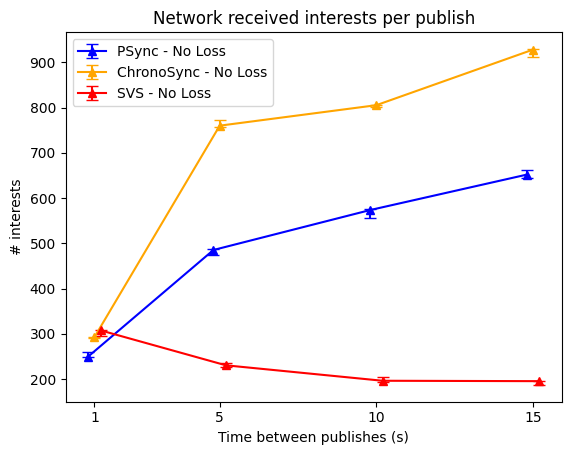

In [23]:
fig, ax = plt.subplots()
ax.set_title('Network received interests per publish')
ax.set_ylabel('# interests')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)


do_plots(NUM_nInInterests, ax)
ax.legend()
display(fig)
plt.close()

Total fraction of messages delivered successfuly. This value may be affected by the convergence time provided at the end of each experiment. Some nodes may also randomly crash affecting the value.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

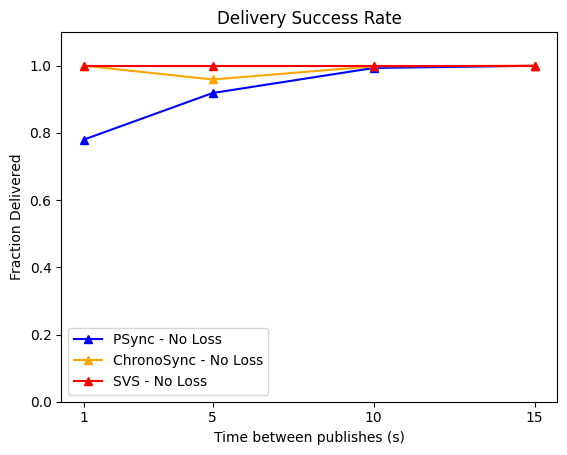

In [24]:
fig, ax = plt.subplots()
ax.set_title('Delivery Success Rate')
ax.set_ylabel('Fraction Delivered')
ax.set_xlabel('Time between publishes (s)')
ax.set_xticks(PUB_TIMING_VALS_SEC)
ax.set_ylim(0, 1.1)

for i, LOG_PREFIX in enumerate(LOG_PREFIXES):
    data = SUCCESS_DATA[LOG_PREFIX]
    ax.plot(PUB_TIMING_VALS_SEC, [np.percentile(x, 50) for x in data], '^-', 
            color=COLORS[i], label=LOG_PREFIX_LABELS[i])

ax.legend()
display(fig)
plt.close()